# Cluster-GCN with StellarGraph

- dataset: local cora dataset

## start with node-classification

In [1]:
import networkx as nx
import stellargraph as sg
import pandas as pd
import numpy as np
import warnings
import tensorflow as tf

from sklearn import preprocessing, model_selection

from tensorflow.keras import layers, Model, optimizers, losses, callbacks

warnings.filterwarnings('ignore')
np.random.seed(0)
tf.random.set_seed(0)

### graph setting

In [2]:
# set edges
edges = pd.read_table('../datasets/cora/cora.cites', header=None)
edges.columns = ['source', 'target'] # should be follow this column name
gx = nx.from_pandas_edgelist(edges) # stellar graph form

# load features
features = pd.read_table('../datasets/cora/cora.content', header=None, index_col=0)
target = pd.Series(features[features.columns[-1]].values, index=features.index.values)
features = features.drop(features.columns[-1], axis=1)
col_names = ['w_'+str(i) for i in range(1, 1434)]
features.columns = col_names


# make graph
G = sg.StellarGraph(gx, node_features=features)
nodes = list(G.nodes())
print(G.info())


StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  default: [2708]
    Features: float32 vector, length 1433
    Edge types: default-default->default

 Edge types:
    default-default->default: [5278]


### val-test split and OHE

In [3]:
tr_target, val_target = model_selection.train_test_split(
    target, train_size=0.2, stratify=target
)

val_target, test_target = model_selection.train_test_split(
    val_target, train_size=0.5, stratify=val_target
)

In [4]:
lbe = preprocessing.LabelBinarizer().fit(target.values)

tr_target = pd.DataFrame(lbe.transform(tr_target.values), index=tr_target.index)
val_target = pd.DataFrame(lbe.transform(val_target.values), index=val_target.index)
test_target = pd.DataFrame(lbe.transform(test_target.values), index=test_target.index)
tot_target = pd.DataFrame(lbe.transform(target.values), index=target.index)

### node generator
-  should produce cluster method
    - default is random and can use metis method

In [5]:
from stellargraph.mapper import ClusterNodeGenerator
# import metis

# edgecuts, parts = metis.part_graph(G, number_of_clusters)
# parts = np.array(parts)
# clusters = []
# cluster_ids = np.unique(parts)
# for cluster_id in cluster_ids:
#     mask = np.where(parts == cluster_id)
#     clusters.append(node_ids[mask])
        
generator = ClusterNodeGenerator(G, clusters=10, q=10, name='generator') # q: clusters per batch


Number of clusters 10
0 cluster has size 270
1 cluster has size 270
2 cluster has size 270
3 cluster has size 270
4 cluster has size 270
5 cluster has size 270
6 cluster has size 270
7 cluster has size 270
8 cluster has size 270
9 cluster has size 278


In [6]:
tr_flow = generator.flow(tr_target.index, tr_target, name='train') # node_id, target
val_flow = generator.flow(val_target.index, val_target, name='val')
test_flow = generator.flow(test_target.index, test_target, name='test')
tot_flow = generator.flow(tot_target.index, tot_target, name='tot')

### build implemented model
- Cluster-GCN need pred_model to predict
- and with pred_model, after predict/fit flow object, the object has node_order
    - due to randomized index, the node_order needed to compare/predict right way

In [7]:
from stellargraph.layer import ClusterGCN
import tensorflow.keras.backend as K
# like keras models
gcn = ClusterGCN(layer_sizes=[32, 32], activations=['elu', 'elu'], generator=generator, dropout=0.5, bias=True)

# build network
nc_inp, nc_out = gcn.build()

nc_layer = layers.Dense(16, activation='relu')(nc_out)
nc_layer = layers.Dense(tr_target.shape[1], activation='softmax')(nc_layer)

nc_model = Model(inputs=nc_inp, outputs=nc_layer)
nc_model.compile(
    optimizer=optimizers.Adam(lr=1e-3),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)


pred_layer = layers.Lambda(lambda x: K.squeeze(x, 0))(nc_layer)
pred_model = Model(nc_inp, pred_layer)

In [8]:
es = callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_acc')
nc_hist = nc_model.fit(tr_flow, epochs=200,
                validation_data=val_flow,
                shuffle=False, # should be False!!
                callbacks=[es],
                verbose=0)  

  ...
    to  
  ['...']
  ...
    to  
  ['...']


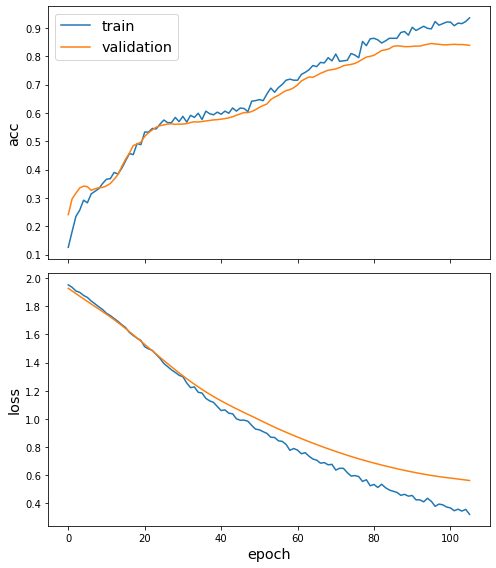

In [9]:
sg.utils.plot_history(nc_hist)

In [10]:
from sklearn.metrics import f1_score

res = list(map(np.argmax, pred_model.predict(test_flow)))
test_label = list(map(np.argmax, test_target.loc[test_flow.node_order].values))

f1_micro = f1_score(test_label, res, average='micro')
f1_marco = f1_score(test_label, res, average='macro')

print('f1_micro:', round(f1_micro,3), '\nf1_macro:', round(f1_marco, 3)) 


f1_micro: 0.837 
f1_macro: 0.825


### comparison with non-graph classification

In [11]:
from sklearn.linear_model import LogisticRegression

tr_tar = list(map(lambda x: np.argmax(x), tr_target.values))
lr = LogisticRegression().fit(features.loc[tr_target.index], tr_tar)

f1_micro = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (lr.predict_proba(features.loc[test_target.index])))), average='micro')
f1_macro = f1_score(list(map(np.argmax, test_target.values)), list(map(np.argmax, (lr.predict_proba(features.loc[test_target.index])))), average='macro')

print('f1_micro:', round(f1_micro,3), '\nf1_macro:', round(f1_marco, 3)) 


f1_micro: 0.71 
f1_macro: 0.825


### visualize how it classify

In [14]:
emb_flat = layers.Lambda(lambda x: K.squeeze(x, 0))(nc_out)
emb_model = Model(nc_inp, emb_flat)

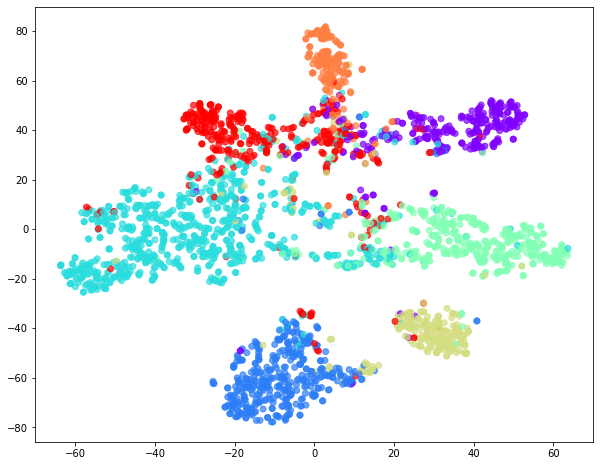

In [20]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2)
tsne_x = tsne.fit_transform(emb_model.predict(tot_flow))

lbe = preprocessing.LabelEncoder()
col = lbe.fit_transform(target.reindex(index=tot_flow.node_order))

alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    tsne_x[:, 0],
    tsne_x[:, 1],
    cmap="rainbow",
    c=col,
    alpha=alpha,
)